# Ingesting Tweets

In [1]:
# imports
from nlp import Dataset
import pandas as pd

In [2]:
# Ingest tweets from the Kaggle disaster tweet competition: https://www.kaggle.com/c/nlp-getting-started

tweets = pd.read_csv('../data/disaster.csv')

print(tweets.shape)

tweets.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


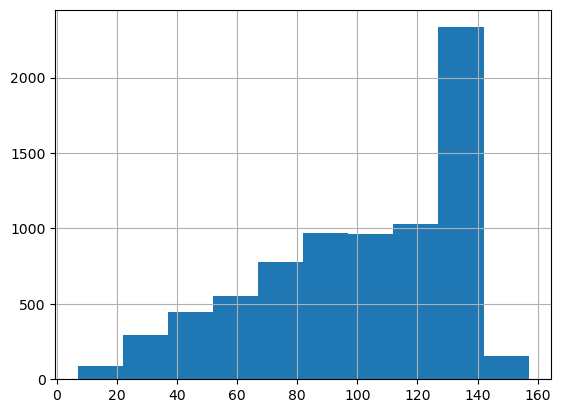

In [3]:
# Histogram of tweet lengths. I don't love the left skewed data

tweets['text'].apply(len).hist()

In [4]:
tweets.shape

(7613, 5)

In [5]:
del tweets['id']
del tweets['keyword']
del tweets['location']

# Preprocessing Tweets

In [6]:
import re

URL_REGEX = re.compile('http(s)?:\/\/t.co\/\w+')
MENTION_REGEX = re.compile('@\w+')

def clean_tweet(tweet):
    # remove mentions, the pound sign, and replace urls with URL token
    tweet = re.sub(URL_REGEX, 'url', tweet)  # replace urls with url. Assumes that the mention of a url is significant
    tweet = re.sub(MENTION_REGEX, '', tweet)  # remove mentions entirely
    tweet = tweet.replace('#', '')  # remove pound signs
    
    return tweet.strip()

In [7]:
clean_tweet('@prof_oz MEG issues Hazardous #Weather Outlook (HWO) http://t.co/3X6RBQJHn3')

'MEG issues Hazardous Weather Outlook (HWO) url'

In [8]:
tweets['text'] = tweets['text'].apply(clean_tweet)

tweets

,text,target
0,Our Deeds are the Reason of this earthquake Ma...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive wildfires evacuation ord...",1
4,Just got sent this photo from Ruby Alaska as s...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,The out of control wild fires in California ev...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. url,1
7611,Police investigating after an e-bike collided ...,1


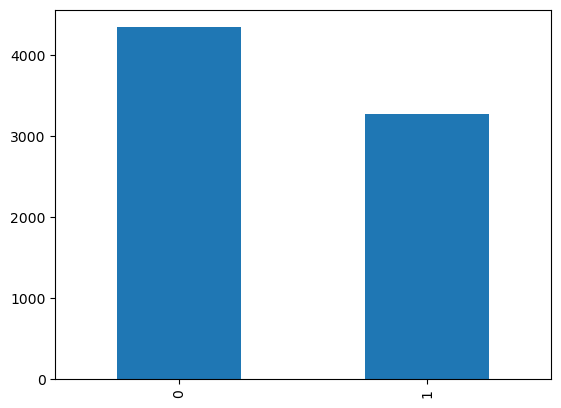

In [9]:
tweets['target'].value_counts().plot(kind='bar')

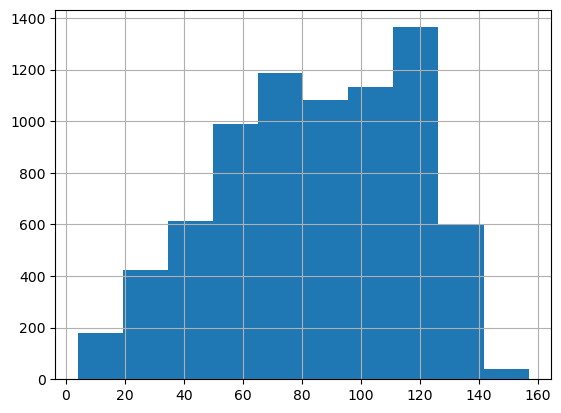

In [10]:
# Histogram of tweet lengths after cleaning. Much more normal :)

tweets['text'].apply(len).hist()

In [11]:
# the trainer is expecting a 'label' (see the forward method in the docs)
tweets['label'] = tweets['target']
del tweets['target']

tweet_dataset = Dataset.from_pandas(tweets)

In [12]:
tweets

,text,label
0,Our Deeds are the Reason of this earthquake Ma...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive wildfires evacuation ord...",1
4,Just got sent this photo from Ruby Alaska as s...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,The out of control wild fires in California ev...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. url,1
7611,Police investigating after an e-bike collided ...,1


In [13]:
BERT_MODEL = 'bert-base-uncased'  # uncased will lowercase everything and remove accents

# reminder uncased vs cased. We are using uncased to simplify and we don't think case will matter here

In [14]:
from transformers import AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)

In [15]:
bert_tokenizer(['hi', 'hello there'], truncation=True)

{'input_ids': [[101, 7632, 102], [101, 7592, 2045, 102]], 'token_type_ids': [[0, 0, 0], [0, 0, 0, 0]], 'attention_mask': [[1, 1, 1], [1, 1, 1, 1]]}

In [16]:
bert_tokenizer(['hi', 'hello there'], truncation=True, padding=True)

{'input_ids': [[101, 7632, 102, 0], [101, 7592, 2045, 102]], 'token_type_ids': [[0, 0, 0, 0], [0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 0], [1, 1, 1, 1]]}

In [17]:
bert_tokenizer.pad_token, bert_tokenizer.pad_token_id

('[PAD]', 0)

In [18]:
bert_tokenizer.vocab['hi']

7632

In [19]:
# simple function to batch tokenize utterances with truncation
def preprocess_function(examples):
    return bert_tokenizer(examples["text"], truncation=True)

tweet_dataset = tweet_dataset.map(preprocess_function, batched=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/8 [00:00<?, ?it/s]

In [20]:
# Dataset has a built in train test split method
tweet_dataset = tweet_dataset.train_test_split(test_size=0.2)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [21]:
tweet_dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, num_rows: 6090),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, num_rows: 1523)}

In [22]:
tweet_dataset.remove_column_('text')  # remove the text column because we don't need to keep it in memory anymore
# this is not required but speeds things up a bit

In [23]:
tweet_dataset

{'train': Dataset(features: {'label': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, num_rows: 6090),
 'test': Dataset(features: {'label': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, num_rows: 1523)}

In [24]:
from transformers import DataCollatorWithPadding

# DataCollatorWithPadding creates batch of data. It also dynamically pads text to the 
#  length of the longest element in the batch, making them all the same length. 
#  It's possible to pad your text in the tokenizer function with padding=True, dynamic padding is more efficient.
data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

In [25]:
tweet_dataset['train'][0]

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [101,
  7752,
  11484,
  26436,
  6613,
  6840,
  1057,
  2080,
  2678,
  24471,
  2140,
  24471,
  2140,
  102],
 'label': 1,
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [26]:
bert_tokenizer.decode(tweet_dataset['train'][0]['input_ids'])

'[CLS] sinkhole swallows brooklyn intersection uo video url url [SEP]'

In [27]:
batch = data_collator(tweet_dataset['train'][:5])

batch

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'input_ids': tensor([[  101,  7752, 11484, 26436,  6613,  6840,  1057,  2080,  2678, 24471,
          2140, 24471,  2140,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  4633, 19939,  2005,  6504,  1037,  1059, 11961,  2140, 11101,
          2003,  2746,  1012,

In [28]:
batch['labels']

tensor([1, 1, 0, 0, 1])

In [29]:
batch['attention_mask']  # 1's where we have tokens we care about and 0 where we don't want to calculate attention

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [30]:
batch['input_ids']  # token ids are padded at the end with 0s

tensor([[  101,  7752, 11484, 26436,  6613,  6840,  1057,  2080,  2678, 24471,
          2140, 24471,  2140,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  4633, 19939,  2005,  6504,  1037,  1059, 11961,  2140, 11101,
          2003,  2746,  1012,  1012,  1012,  1016,  2244, 24471,  2140,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  2293, 12701,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  1045,  1012,  1012,  1012,  1045,  2453,  4965,  2026,  9686,
         29112,  5195,  2005, 28625, 21197,  2937,  1012,  1012,  1012,   102,
             0,     0,     0,     0,  

In [31]:
bert_tokenizer.decode(batch['input_ids'][0])  # see the pad tokens. 0 --> [PAD]

'[CLS] sinkhole swallows brooklyn intersection uo video url url [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [32]:
BERT_MODEL

'bert-base-uncased'

In [33]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification

sequence_classification_model = AutoModelForSequenceClassification.from_pretrained(
    BERT_MODEL, 
    num_labels=2,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)

sequence_classification_model.config.id2label = {0: 'NOT DISASTER', 1: 'DISASTER'}

sequence_classification_model

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [34]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_71109/676540184.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [35]:
batch_size = 32
epochs = 2

training_args = TrainingArguments(
    output_dir='./clf/results',
    logging_dir='./clf/logs',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_strategy='steps',
    logging_first_step=True,
    load_best_model_at_end=True,
    logging_steps=1,
    evaluation_strategy='epoch',
    eval_steps=1,
    save_strategy='epoch',
)

# Define the trainer: 

trainer = Trainer(
    model=sequence_classification_model,
    args=training_args,
    train_dataset=tweet_dataset['train'],
    eval_dataset=tweet_dataset['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [36]:
# Get initial metrics
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1523
  Batch size = 32


{'eval_loss': 0.714587926864624,
 'eval_accuracy': 0.43204202232435984,
 'eval_runtime': 17.9273,
 'eval_samples_per_second': 84.954,
 'eval_steps_per_second': 2.677}

In [37]:
trainer.train()

/opt/homebrew/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6090
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 382


Epoch,Training Loss,Validation Loss,Accuracy
1,0.320500,0.364168,0.846356
2,0.165800,0.406036,0.845043


***** Running Evaluation *****
  Num examples = 1523
  Batch size = 32
Saving model checkpoint to ./clf/results/checkpoint-191
Configuration saved in ./clf/results/checkpoint-191/config.json
Model weights saved in ./clf/results/checkpoint-191/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1523
  Batch size = 32
Saving model checkpoint to ./clf/results/checkpoint-382
Configuration saved in ./clf/results/checkpoint-382/config.json
Model weights saved in ./clf/results/checkpoint-382/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./clf/results/checkpoint-191 (score: 0.36416804790496826).


TrainOutput(global_step=382, training_loss=0.368179048816259, metrics={'train_runtime': 561.2325, 'train_samples_per_second': 21.702, 'train_steps_per_second': 0.681, 'total_flos': 256322584576200.0, 'train_loss': 0.368179048816259, 'epoch': 2.0})

In [38]:
# Get post-training metrics
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1523
  Batch size = 32


{'eval_loss': 0.36416804790496826,
 'eval_accuracy': 0.8463558765594222,
 'eval_runtime': 19.1949,
 'eval_samples_per_second': 79.344,
 'eval_steps_per_second': 2.501,
 'epoch': 2.0}

In [39]:
trainer.save_model()  # save our best model

Saving model checkpoint to ./clf/results
Configuration saved in ./clf/results/config.json
Model weights saved in ./clf/results/pytorch_model.bin


In [40]:
from transformers import pipeline

# make a classification pipeline
pipe = pipeline("text-classification", './clf/results', tokenizer=BERT_MODEL)

loading configuration file ./clf/results/config.json
Model config BertConfig {
  "_name_or_path": "./clf/results",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NOT DISASTER",
    "1": "DISASTER"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": null,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration file ./clf/results/config.json
Model config BertConfig {
  "_name_or_path": "./clf/results"

In [41]:
pipe('this is awful. Such a terrible earthquake')

[{'label': 'DISASTER', 'score': 0.962486982345581}]

In [42]:
# show scores for all classes
pipe('this is awful. Such a terrible earthquake', return_all_scores=True)

/opt/homebrew/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:89: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'NOT DISASTER', 'score': 0.03751305118203163},
  {'label': 'DISASTER', 'score': 0.962486982345581}]]